In [121]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cats-vs-dogs/readme[1].txt
/kaggle/input/cats-vs-dogs/MSR-LA - 3467.docx
/kaggle/input/cats-vs-dogs/PetImages/Dog/7981.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/6234.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/1269.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/3863.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/6241.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/10304.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/623.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/2193.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/11925.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/3750.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/11378.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/2008.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/10730.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/5982.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/7737.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/2081.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/10597.jpg
/kaggle/input/cats-vs-dogs/PetImages/Dog/6588.jpg
/kaggle/i

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, models, transforms
from PIL import Image

import time
import os
import copy

In [123]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print (device)

cuda


In [124]:
def cleanimagefolder(image_folder):
    valid_samples = []
    dataset = datasets.ImageFolder(root=image_folder)
    for path, data in dataset.samples:
        try:
            with Image.open(path) as img:
                img.verify()   # Check if image is valid
            valid_samples.append((path, data))
        except:
            pass  # Skip corrupted images
    dataset.samples = valid_samples
    dataset.img = valid_samples

    return dataset

In [136]:
cat_data_dir = '/kaggle/input/cats-vs-dogs/PetImages'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = cleanimagefolder(cat_data_dir)
print("Total Image : ",len(full_dataset))

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print("Training Dataset Images Count : ", len(train_dataset), " Valdataion Dataset Image Count : ",len(val_dataset))

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform= data_transforms['val']

dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}

class_names = train_dataset.dataset.classes

Total Image :  24998
Training Dataset Images Count :  19998  Valdataion Dataset Image Count :  5000


In [126]:
train_set = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_set = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [127]:
def imshow(inp, title=None):

    # transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0))

    # use default values for mean and std
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # To visualize the correct colors
    inp = std * inp + mean

    # To view a clipped version of an image
    inp = np.clip(inp, 0, 1)

    # Visualize inp
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

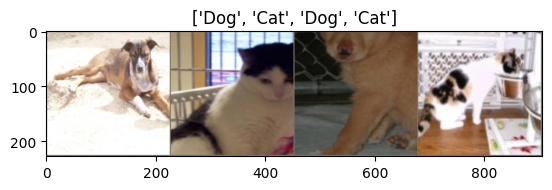

In [128]:
# get a batch of training data
inputs, classes = next(iter(train_set))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

# plot the grid with a title that concatenates all the class labels
imshow(out, title=[class_names[x] for x in classes])

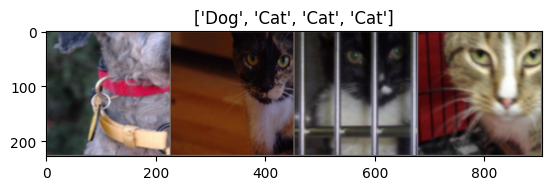

In [129]:
# get a batch of training data
inputs, classes = next(iter(val_set))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

# plot the grid with a title that concatenates all the class labels
imshow(out, title=[class_names[x] for x in classes])

In [147]:
def train_model(model, criterion, optimizer, scheduler, num_epoch =10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epoch):
        print(f'Epoch {epoch+1}/{num_epoch}:')
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   
                loader = train_set
            else:
                model.eval()  
                loader = val_set

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)           # Forward pass
                    _, preds = torch.max(outputs, 1)  # Get predictions
                    loss = criterion(outputs, labels) # Calculate loss
                    

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # Calculate epoch stats
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'  {phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Training complete
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_accuracy:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [131]:
def vaisualize_model(model, num_images=6):

    was_trainng = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_set):   
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [145]:
model_ft = models.resnet18(weights=True)
run_fltr = model_ft.fc.in_features
# model_ft.fc = nn.Linear(run_fltr, 2)
model_ft = model_ft.to(device)

# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [148]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/10:
------------------------------
  train Loss: 0.1791  Acc: 0.9274
  val Loss: 0.0889  Acc: 0.9652

Epoch 2/10:
------------------------------
  train Loss: 0.1689  Acc: 0.9317
  val Loss: 0.0871  Acc: 0.9644

Epoch 3/10:
------------------------------
  train Loss: 0.1722  Acc: 0.9294
  val Loss: 0.0906  Acc: 0.9646

Epoch 4/10:
------------------------------
  train Loss: 0.1691  Acc: 0.9333
  val Loss: 0.1000  Acc: 0.9598

Epoch 5/10:
------------------------------
  train Loss: 0.1707  Acc: 0.9305
  val Loss: 0.1098  Acc: 0.9564

Epoch 6/10:
------------------------------
  train Loss: 0.1653  Acc: 0.9343
  val Loss: 0.0887  Acc: 0.9662

Epoch 7/10:
------------------------------
  train Loss: 0.1681  Acc: 0.9338
  val Loss: 0.1095  Acc: 0.9564

Epoch 8/10:
------------------------------
  train Loss: 0.1638  Acc: 0.9351
  val Loss: 0.0843  Acc: 0.9662

Epoch 9/10:
------------------------------
  train Loss: 0.1661  Acc: 0.9332
  val Loss: 0.0798  Acc: 0.9696

Epoch 10/1

In [149]:
def visualize_model(model, num_images=8):

    was_training = model.training
    model.eval()
    images_displayed = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_set):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_displayed += 1
                ax = plt.subplot(num_images//2, 2, images_displayed)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_displayed == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

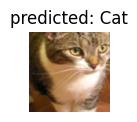

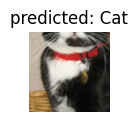

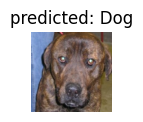

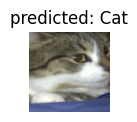

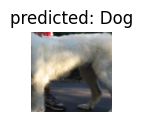

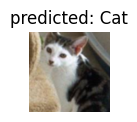

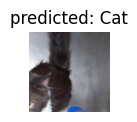

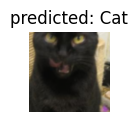

In [151]:
visualize_model(model_ft)